# Optimization of hyper-parameters

The model evidence cannot only be used to compare different kinds of time series models, but also to optimize the hyper-parameters of a given transition model by maximizing its evidence value. The `Study` class of *bayesloop* contains a method `optimize` which relies on the `minimize` function of the `scipy.optimize` module. Since *bayesloop* has no gradient information about the hyper-parameters, the optimization routine is based on the [COBYLA](https://en.wikipedia.org/wiki/COBYLA) algorithm. The following two sections introduce the optimization of hyper-parameters using *bayesloop* and further describe how to selectively optimize specific hyper-parameters in nested transition models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # nicer plots
sns.set_style('whitegrid')      # plot styling

import numpy as np
import bayesloop as bl

# prepare study for coal mining data
S = bl.Study()
S.loadExampleData()
S.setObservationModel(bl.om.Poisson('accident rate', bl.oint(0, 6, 1000)))

+ Created new study.
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['accident rate']


## Global optimization

The `optimize` method supports all currently implemented transition models with continuous hyper-parameters, as well as combinations of multiple models. The change-point model as well as the serial transition model represent exceptions here, as their parameters `tChange` and `tBreak`, respectively, are discrete. These discrete pratemers are ignored by the optimization routine. See the [tutorial on change-point studies](changepointstudy.html) for further information on how to analyze structural breaks and change-points. By default, all continuous hyper-parameters of the transition model are optimized. *bayesloop* further allows to selectively optimize specific hyper-parameters, see [below](#Conditional-optimization-in-nested-transition-models). The parameter values set by the user when defining the transition model are used as starting values. During optimization, only the log-evidence of the model is computed. When finished, a full fit is done to provide the parameter distributions and mean values for the optimal model setting.

We take up the coal mining example again, and stick with the serial transition model defined [here](modelselection.html#Serial-transition-model). This time, however, we optimize the slope of the linear decrease from 1885 to 1895 and the magnitude of the fluctuations afterwards (i.e. the standard deviation of the Gaussian random walk):

+ Transition model: Serial transition model. Hyper-Parameter(s): ['slope', 'sigma', 't_1', 't_2']
+ Starting optimization...
  --> All model parameters are optimized (except change/break-points).
    + Log10-evidence: -72.93384 - Parameter values: [-0.2  0.1]
    + Log10-evidence: -96.81252 - Parameter values: [ 0.8  0.1]
    + Log10-evidence: -75.18192 - Parameter values: [-0.2  1.1]
    + Log10-evidence: -78.43877 - Parameter values: [-1.19559753  0.00626873]
    + Log10-evidence: -78.80509 - Parameter values: [-0.69779877  0.05313437]
    + Log10-evidence: -85.79404 - Parameter values: [ 0.04572939  0.05398839]
    + Log10-evidence: -72.76628 - Parameter values: [-0.21058883  0.34977565]
    + Log10-evidence: -73.72301 - Parameter values: [-0.33553394  0.34607154]
    + Log10-evidence: -74.02943 - Parameter values: [-0.08663732  0.3659319 ]
    + Log10-evidence: -73.17022 - Parameter values: [-0.14861308  0.35785378]
    + Log10-evidence: -72.79393 - Parameter values: [-0.21462789  

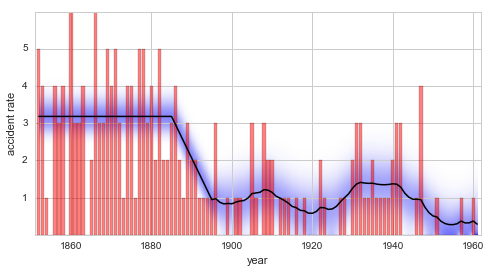

In [2]:
# define linear decrease transition model
def linear(t, slope=-0.2):
    return slope*t

T = bl.tm.SerialTransitionModel(bl.tm.Static(),
                                bl.tm.BreakPoint('t_1', 1885),
                                bl.tm.Deterministic(linear, target='accident rate'),
                                bl.tm.BreakPoint('t_2', 1895),
                                bl.tm.GaussianRandomWalk('sigma', 0.1, target='accident rate'))
S.setTransitionModel(T)

S.optimize()

plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution('accident rate')
plt.xlim([1851, 1962])
plt.xlabel('year');

The optimal value for the standard deviation of the varying disaster rate is determined to be $\approx 0.23$, the initial guess of $\sigma = 0.1$ is therefore too restrictive. The value of the slope is only optimized slightly, resulting in an optimal value of $\approx -0.22$. The optimal hyper-parameter values are displayed in the output during optimization, but can also be inspected directly:

In [3]:
print 'slope =', S.getHyperParameterValue('slope')
print 'sigma =', S.getHyperParameterValue('sigma')

slope = -0.223240841019
sigma = 0.228462963962


## Conditional optimization in nested transition models

The previous section introduced the `optimize` method of the `Study` class. By default, all (continuous) hyper-parameters of the chosen transition model are optimized. In some applications, however, only specific hyper-parameters may be subject to optimization. Therefore, a list of parameter names (or a single name) may be passed to `optimize`, specifying which parameters to optmize. Note that all hyper-parameters have to be given a unique name. An example for a (quite ridiculously) nested transition model is defined below. Note that the deterministic transition models are defined via `lambda` functions.

In [4]:
T = bl.tm.SerialTransitionModel(bl.tm.CombinedTransitionModel(
                                    bl.tm.GaussianRandomWalk('early_sigma', 0.05, target='accident rate'),
                                    bl.tm.RegimeSwitch('pmin', -7)
                                    ),
                                bl.tm.BreakPoint('first_break', 1885),
                                bl.tm.Deterministic(lambda t, slope_1=-0.2: slope_1*t, target='accident rate'),
                                bl.tm.BreakPoint('second_break', 1895),
                                bl.tm.CombinedTransitionModel(
                                    bl.tm.GaussianRandomWalk('late_sigma', 0.25, target='accident rate'),
                                    bl.tm.Deterministic(lambda t, slope_2=0.0: slope_2*t, target='accident rate')
                                    )
                                )
S.setTransitionModel(T)

+ Transition model: Serial transition model. Hyper-Parameter(s): ['early_sigma', 'pmin', 'slope_1', 'late_sigma', 'slope_2', 'first_break', 'second_break']


This transition model assumes a combination of gradual and abrupt changes until 1885, followed by a deterministic decrease of the annual disaster rate until 1895. Afterwards, the disaster rate is modeled by a combination of a decreasing trend and random fluctuations. Instead of discussing exactly how meaningful the proposed transition model really is, we focus on how to specify different (groups of) hyper-parameters that we might want to optimize.

All hyper-parameter names occur only once within the transition model and may simply be stated by their name: `S.optimize('pmin')`. Note that you may also pass a single or multiple hyper-parameter(s) as a list: `S.optimize(['pmin'])`, `S.optimize(['pmin', 'slope_2'])`. For deterministic models, the argument name also represents the hyper-parameter name:

In [5]:
S.optimize(['slope_2'])

+ Starting optimization...
  --> Parameter(s) to optimize: ['slope_2']
    + Log10-evidence: -72.78352 - Parameter values: [ 0.]
    + Log10-evidence: -93.84882 - Parameter values: [ 1.]
    + Log10-evidence: -80.98325 - Parameter values: [-1.]
    + Log10-evidence: -85.81409 - Parameter values: [-0.5]
    + Log10-evidence: -82.83302 - Parameter values: [ 0.25]
    + Log10-evidence: -73.27797 - Parameter values: [-0.125]
    + Log10-evidence: -74.00209 - Parameter values: [ 0.0625]
    + Log10-evidence: -72.56560 - Parameter values: [-0.03125]
    + Log10-evidence: -72.59014 - Parameter values: [-0.0625]
    + Log10-evidence: -72.54880 - Parameter values: [-0.046875]
    + Log10-evidence: -72.59014 - Parameter values: [-0.0625]
    + Log10-evidence: -72.56237 - Parameter values: [-0.0546875]
    + Log10-evidence: -72.54744 - Parameter values: [-0.04296875]
    + Log10-evidence: -72.54976 - Parameter values: [-0.0390625]
    + Log10-evidence: -72.54814 - Parameter values: [-0.04101562]


Although the optimization of hyper-parameters helps to objectify the choice of hyper-parameter values and may even be used to gain new insights into the dynamics of systems, optimization alone does not provide any measure of uncertainty tied to the obtained, optimal hyper-parameter value. [The next tutorial](hyperstudy.html) discusses an approach to infer not only the time-varying parameter distributions, but also the distribution of hyper-parameters.